### This notebook is designed to pratice with both geopandas and census data.  This is a simple spatial exploratory analysis of census data. The goal is to assess wheather the location of the [linkNYC](https://www.link.nyc/) access points is optimal to guarantee a more "democratic" access to the internet.

# 1. PUMA : Public Use Microdata Area
Census geographies that are not specific political entities (i.e. states, counties etc) are designed for homogeneity so that aggregating the data over the whole area will leat to an estimat (mean or median for example) with minimal variance. Among these geographies are the _census tracts_, _census blocks_, and _Public Use Microdata Areas (PUMAs)_. PUMAs are geographical areas designed to aggregate census data. Each PUMA contains at least 100,000 people. PUMAs do not overlap, and are contained within a single state. 

## 1.1 download the NYC  Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data

PUMAs were first created for the 1990 Census. PUMAs are identified by a specific 4 numbers id. In the shapefile foung at data.cityofnewyork.us the id is named "puma" and it is in fact a 4 digits number. You can read it in as an integer (although of course it is a categorical variable inherently!). Often the PUMA id is found in conjunction with the 3 numbers state id, leading to a 7 numbers identification. The id for the State of NY is 036. See this link for more: https://www.census.gov/geo/reference/geoidentifiers.html


In [1]:
import urllib
import requests
import json
import io
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import pylab as pl
import os
import shapely
from fiona.crs import from_epsg
from geopandas import GeoDataFrame
import geopandas as gp
from shapely.geometry import Point

%matplotlib inline

In [2]:
# reading in data from url for reproducability
!wget http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nypuma_17d.zip 

# unpack the data into PUIdata dircetory
cmd = "mv nypuma_17d.zip " + os.getenv("PUIDATA")

#let's see it
print (cmd)

--2017-11-27 22:08:58--  http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nypuma_17d.zip
Resolving www1.nyc.gov... 23.203.16.166, 2600:141b:13:292::1500, 2600:141b:13:297::1500
Connecting to www1.nyc.gov|23.203.16.166|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 761605 (744K) [application/zip]
Saving to: “nypuma_17d.zip”

100%[======================================>] 761,605     --.-K/s   in 0.1s    

2017-11-27 22:08:58 (7.14 MB/s) - “nypuma_17d.zip” saved [761605/761605]

mv nypuma_17d.zip /home/cusp/ses515/PUIdata


In [4]:
# move 
os.system(cmd)

0

In [5]:
# read in with goepandas
!unzip -d $PUIDATA nypuma_17d.zip
!ls $PUIDATA

unzip:  cannot find or open nypuma_17d.zip, nypuma_17d.zip.zip or nypuma_17d.zip.ZIP.
201501-citibike-tripdata.csv	      nypuma.dbf
201501-citibike-tripdata.zip	      nypuma.prj
201506-citibike-tripdata.csv	      nypuma.shp
201506-citibike-tripdata.zip	      nypuma.shp.xml
ACS_16_1YR_final.csv		      nypuma.shx
ACS_16_1YR_GCT2801.ST50_with_ann.csv  puma.gz
departureZIP.csv		      rows.csv
destinationZIP.csv		      yc200902_income_final.csv
Manhattan			      yc200902_short_with_duration.csv
MN.csv				      yc200902_tripdata_trimmed.csv
nypuma_17d.zip


In [6]:
!ls $PUIDATA

201501-citibike-tripdata.csv	      nypuma.dbf
201501-citibike-tripdata.zip	      nypuma.prj
201506-citibike-tripdata.csv	      nypuma.shp
201506-citibike-tripdata.zip	      nypuma.shp.xml
ACS_16_1YR_final.csv		      nypuma.shx
ACS_16_1YR_GCT2801.ST50_with_ann.csv  puma.gz
departureZIP.csv		      rows.csv
destinationZIP.csv		      yc200902_income_final.csv
Manhattan			      yc200902_short_with_duration.csv
MN.csv				      yc200902_tripdata_trimmed.csv
nypuma_17d.zip


In [7]:
pumashp = gp.read_file(os.getenv("PUIDATA") + "/nypuma.shp")
pumashp.head()

,PUMA,Shape_Leng,Shape_Area,geometry
0,3701,53227.144357,9.792852e+07,"POLYGON ((1012885.033996582 268830.4841918945,..."
1,3702,106050.002507,1.889860e+08,"POLYGON ((1021632.335632324 267934.4393920898,..."
2,3703,304070.209400,2.670137e+08,(POLYGON ((1042822.450195312 243439.8142089844...
3,3704,47970.901277,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045898,..."
4,3705,68630.512052,1.224950e+08,"POLYGON ((1015377.269592285 238959.5014038086,..."


In [8]:
pumashp.crs

{u'datum': u'NAD83',
 u'lat_0': 40.16666666666666,
 u'lat_1': 40.66666666666666,
 u'lat_2': 41.03333333333333,
 u'lon_0': -74,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'us-ft',
 u'x_0': 300000,
 u'y_0': 0}

## 1.2  plot the PUMA NYC regions

you can use the geopandas function plot. 
What is the appropriate plot to just show the shape of the PUMA regions? A choropleth could be ok, but it is better to just draw the contours of the region, since we do not want to highlight some regions over others by color choices. 

(Note: a while ago I wrote a quick function that plots choropleths and maps of NYC specifically putting legends and colorbars in the empty spaces taking advantage of the shape of the city and you are welcome to use it: https://github.com/fedhere/choroplethNYC. BUT YOU DO NOT HAVE TO)



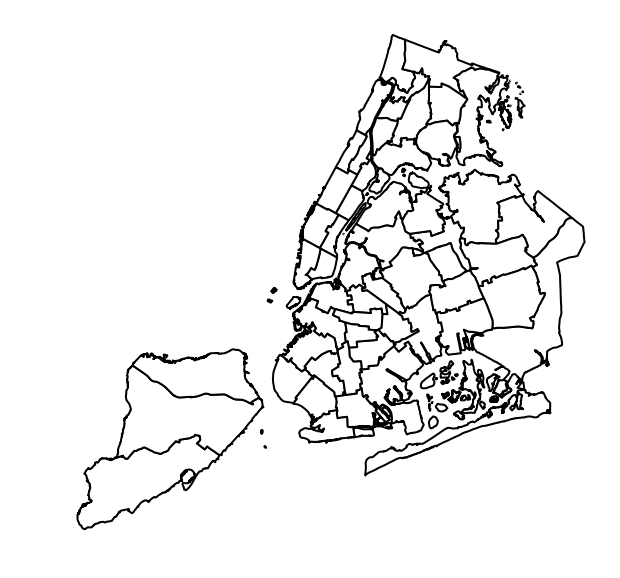

In [9]:
# reading in using @fedhere function for choropleth
import choroplethNYC as cp
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2);

**Figure 1:** This shows the PUMA regions for the five boroughs of NYC. 

___

# 2. American Fact Finder data on percentage of houses with broadband internet access

Download the table of data from 2016 for NYC: you want to obtain data on broadband access (percentage of households with broadband access) at the PUMA (Public Use Microdata Area) geographical area level. 

This may be tricky. But familiarizing with Census and American Commjunity Survey data is super important for urban science. Here you should use the API, but you should also practice interacting with the website: 

You  should read the data in thgouth the API but also download the data manually and compare the two datasets.

## 2.1 Get data with American Fact Finder (AFF) API: 
you can request an API key, although I think it is not necessary for this search (but it is good to practice). Obtain a key and save it into a python file. DO NOT UPLOAD THE FILE CONTAINING THE API KEY TO GITHUB. Keep your API keys private. 

In [10]:
with open('censusAPI.txt', 'r') as f:
    myAPI = f.readline()

If you need help with the API you can ask questions in this [Gitter channel](https://gitter.im/uscensusbureau/general) (I did myself to design this homework!) 
The internet subscription by household is data surveyd annually. You can find out what are the features that you can query through the API for the annually surveyed data at this url: https://api.census.gov/data/2016/acs/acs1/variables.json

read it in as a jason file - you can do it with pandas (but it is slow). You can do it as I do below with the request package

In [11]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [12]:
#turning things into arrays to enable broadcasting
#Python3
# affkeys = np.array(list(aff1y['variables'].keys()))
# Python2
affkeys = np.array(aff1y['variables'].keys())

You need two features: **total number of households**, and **number of households with broadband access**

Broadband access is one of the B28002 keys. However there are many of those! Each variable has several observations associated to it: B28002 is all internet access data (broadband, dial up, none, ...), and for each of those you have the estimate (count, mean, median, percentage...), the margin of errors, and annotations. Those are identified by an appendix that begins with "\_". Look carefully at the line of code below and its output. I am creating a list that contains the keys of the dictionary I created from the json file for all B28002 observations  (rows that start with "B28002") that include the word "Broadband" in the description.

The syntax is a lost comprehension:

        as = \[a for a in listOfAs\] 

is simply a compact way to write

        as = \[\]
        for a in listOfAs:
            as.append(a)
            
with an if statement tha selects broadband         

In [13]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[(u'B28002_008E',
  u'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 (u'B28002_008M',
  u'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 (u'B28002_004MA',
  u'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 (u'B28002_008MA',
  u'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 (u'B28002_004E',
  u'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 (u'B28002_004M',
  u'Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 (u'B28002_007MA',
  u'Annotation of Ma

chose the appropriate variable and extract the relevant data: below I select the variable containing the number of household per PUMA. The "all" variable, which tells you what is the total number of units queried (households here) is generally stored in the \_001 variable (B28002_001 in this case). "E" stands for *estimate*. M stands for *margin of error*, EA *estimate annotations*, MA *margin of error annotations*. You want the estimate for this exercise. 

In [14]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{u'attributes': u'B28002_001M,B28002_001EA',
 u'concept': u'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 u'group': u'B28002',
 u'label': u'Estimate!!Total',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

Similarly, choose the fractions of houses with any "With an Internet subscription!!Broadband of any type"

In [15]:
#keyword for the number of households with broadband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{u'attributes': u'B28002_004M,B28002_004EA',
 u'concept': u'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 u'group': u'B28002',
 u'label': u'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

Now that you have the variable names use them to extract the relevant data with the ACS API. 

The API url is as follows:

root: https://api.census.gov/data/2016/acs/acs1

action: get=\[variable Name\],NAME

geometry: for=\[geometry\]:\[desired geometry values\]in=\[larger geometry\]:\[desired larger geometry values\]

API key: key:\[api key\]

the URL is constructed as root?action&geometry&key

Note that it took me a long time to figure out how to request the right geometry: in the url I write below the geometry is "public%20use%20microdata%20area" where %20 is the character for ' ' (space) in a url, and ":\*" means all PUMAS

state:36 is New York State

In [16]:
# getting the broadband access number of households
urlBB = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
respBB = requests.request('GET', urlBB).content
pumaBB = pd.read_csv(io.StringIO(respBB.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [17]:
#getting the first row of the table: the total number of households
urlHH = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
respHH = requests.request('GET', urlHH).content
pumaHH = pd.read_csv(io.StringIO(respHH.decode('utf-8').replace('[','').replace(']','')))

pumaHH.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 generate a feature for the percentage of households with broadband access

In [18]:
pumaHHBB = pd.merge(pumaHH, pumaBB, on='public use microdata area')
pumaHHBB['percent_BB'] = pumaHHBB['B28002_004E']/pumaHHBB['B28002_001E']* 100
pumaHHBB.head()


,B28002_001E,NAME_x,state_x,public use microdata area,Unnamed: 4_x,B28002_004E,NAME_y,state_y,Unnamed: 4_y,percent_BB
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN,32607,"St. Lawrence County PUMA, New York",36,NaN,80.552879
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,NaN,75.733321
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN,41210,"Warren & Washington Counties PUMA, New York",36,NaN,79.842678
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,NaN,81.433409
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,47786,Oneida County (Central)--Greater Utica & Rome ...,36,NaN,78.150656


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

Manually you can download the GCT Geographic Comparison Tables. Download the GCT table that contains the percentage of households in each PUMA with broadband internet subscription as follows:

https://factfinder.census.gov/ -> Advanced Search -> Show me all 

    - Topics: Product Type -> Geography Comparison Table 
    
select the PERCENT OF HOUSEHOLDS WITH A BROADBAND INTERNET SUBSCRIPTION  at our geography granularity (PUMA) and click Download below. This will generate the table on the fly and you can click again on Download.

Move the file into the PUIdata directory, unzip it and load it with pandas.
    
Your table shold be labeled as: GCT2801	

One more hurdle: you need to move this data to jupyterhub/compute, and the link is not something you can copy and paste!
Two solutions:

-easier but less preferible: upload the table you downloaded locally to github AWS, or else where, and download it from compute

-otherwise, learn how to do it with sftp from your local terminal: these are the steps

1. ON YOUR LOCAL MACHINE where you downloaded the table (which was downloaded as aff_download.zip for me in my ~/Downloads folder) type the following *sftp* command
        
        fbianco@Federicas-MacBook-Air:~$ sftp fbianco@staging.cusp.nyu.edu
    
2. Input your password
            
        Password: 
        Connected to staging.cusp.nyu.edu.

   This should open an sftp promopt (you should see sftp> at the beginning of the line). Go to the PUI directory (for me /home/fbianco/PUIdata)
    
        sftp> cd /home/fbianco/PUIdata             
        
3. Use the sftp command _put_ to copy the file from the local to the remote machine to compute, making sure you use the full path (unless the file was downloaded in your local directory in the local machine)
    
        sftp> put /Users/fbianco/Downloads/aff_download.zip
        
You should see:

            Uploading /Users/fbianco/Downloads/aff_download.zip to ....

And the file can be unzipped and read into your code with pandas. I leave the read in line below for your convenience, those are the only variables you need.

In [19]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,36,81.7,0.2
2,3600100,80.6,2.6
3,3600200,75.7,2.2
4,3600300,79.8,2.6


notice 2 things:
    - that the Target Geo Id2: GCT_STUB.target-geo-id2 is a 7 digits number. See my comment above about it. 
    - that there is a weird double header. You can deal with it in one of 2 ways: either reread the file in skipping one row and using the second row as header, or remove that row (for example with bbpc.drop(0, inplace=True)) but also then you should check the *type* of your GCT_STUB.target-geo-id2 feature! The fact that pandas had to read in a column with nombers and characters forced it to read it as a string, and you need to convert it (.astype(int)) to merge it easily with the API acquired data.
    
In the API dataframe the PUMA id was a 4 digit number. If you have them both as integers and you remove the initial three digits (for example by subtracting 360000 from each value wich you can do as bbpc["gid"] = bbpc.gid - 3600000 then you can merge on the puma id 

In [20]:
bbpc.drop(0, inplace=True)

In [21]:
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
1,36,81.7,0.2
2,3600100,80.6,2.6
3,3600200,75.7,2.2
4,3600300,79.8,2.6
5,3600401,81.4,2.4


In [22]:
# rename to gid
bbpc.rename(columns={'GCT_STUB.target-geo-id2': 'gid'}, inplace=True)

# convert GCT to int
bbpc['gid'] = bbpc['gid'].astype(int)

# subtract 3600000 so we can merge appropriately
bbpc['gid'] = bbpc.gid - 3600000
bbpc.head()

,gid,HC01,HC02
1,-3599964,81.7,0.2
2,100,80.6,2.6
3,200,75.7,2.2
4,300,79.8,2.6
5,401,81.4,2.4


## check that the percentage of households with broadband you generated and the one you red in from the table you downloaded manually are the same

In [23]:
# merge on gid
diff_ = pumaHHBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["percent_BB", "HC01"]]

# look at the difference
diff_["diff"] = np.abs(diff_["percent_BB"] - diff_["HC01"].astype(float))

diff_.describe()

,percent_BB,diff
count,145.000000,145.000000
mean,81.845478,0.026217
std,7.063369,0.014480
min,54.932945,0.000178
25%,77.770257,0.012252
50%,82.826141,0.027230
75%,87.305077,0.039090
max,93.404143,0.049872


the maximum difference should only be a few percent

# 3 Plot a choropleth of NYC broadband access 
pumashp.PUMA = pumashp.PUMA.astype(int)## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [24]:
pumashp.PUMA = pumashp.PUMA.astype(int)
puma_geo = pumashp.merge(pumaHHBB, left_on='PUMA', right_on='public use microdata area')
puma_geo.head()

,PUMA,Shape_Leng,Shape_Area,geometry,B28002_001E,NAME_x,state_x,public use microdata area,Unnamed: 4_x,B28002_004E,NAME_y,state_y,Unnamed: 4_y,percent_BB
0,3701,53227.144357,9.792852e+07,"POLYGON ((1012885.033996582 268830.4841918945,...",42158,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN,84.275820
1,3702,106050.002507,1.889860e+08,"POLYGON ((1021632.335632324 267934.4393920898,...",49817,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN,68.310015
2,3703,304070.209400,2.670137e+08,(POLYGON ((1042822.450195312 243439.8142089844...,44329,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN,82.826141
3,3704,47970.901277,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045898,...",44476,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN,72.553737
4,3705,68630.512052,1.224950e+08,"POLYGON ((1015377.269592285 238959.5014038086,...",58706,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,NaN,69.425612


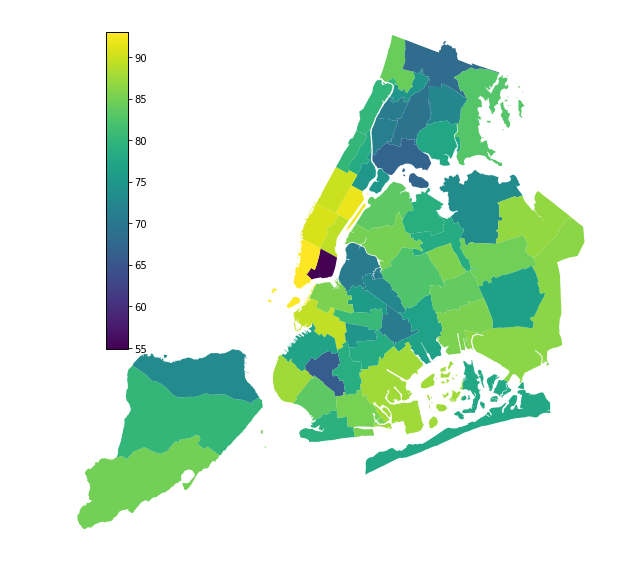

In [25]:
#choropleth of the percentage of internet acess

cp.choroplethNYC(puma_geo, column='percent_BB', lw=2);

**Figure 2:** This map show the percentage of households that have broadband internet in each PUMA of NYC. The lighter colors show areas that have the highest percentages. The light areas of Manhattan make sense with what we know to be the socioeconomic background of that area. There is one outlier in the south eastern corner of Manhattan. It seems unusual that this area would have such a low percentage; further investigation is needed. 

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

acquire the linkNYC locations and prepare them into a dataframe
read it in from the HW9_fb55 folder in :
https://github.com/fedhere/PUI2017_fb55

Notice that you can also get a linkNYC locations shapefile from NYC open data, as I did to generate this, but I want you do to do some extra coordinates gymnastics for practice so use the one I provide.

In [26]:
linkNYC = pd.read_csv('https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv')

In [27]:
(linkNYC.longitude).astype(float)
(linkNYC.latitude).astype(float)
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


## combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame _linkNYC_ and set native coordinates  frame to lat/lon as you did in the lab
    linkNYC.crs = ...

In [28]:
# combine lat and lon to one column
linkNYC['lonlat'] = zip(linkNYC['longitude'], linkNYC['latitude'])

# create a point geometry for lat long column
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

# convert back into a geodataframe
geometry = linkNYC.geometry
crs = {'init': 'epsg:4326'}
linkBB = GeoDataFrame(linkNYC, crs=crs, geometry=geometry)

# let's see what we're working with 
linkBB.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [29]:
linkBB.crs

{'init': 'epsg:4326'}

# plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in *5 equal intervals*

I have also color coded the station by how long ago they have been installed, using the date datetime variable

In [30]:
# convert to same projection
puma_geo = puma_geo.to_crs(epsg=4326)

In [31]:
# check that they're the same
print linkBB.crs
print puma_geo.crs

{'init': 'epsg:4326'}
{'init': 'epsg:4326', 'no_defs': True}


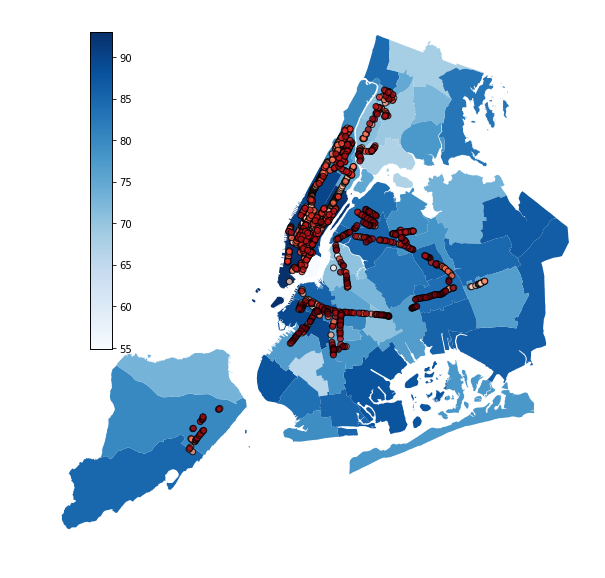

In [34]:
# source: https://github.com/fedhere/PUI2017_fb55/blob/master/HW9_fb55/pandasGeospatialABC.ipynb

# plotting the basemap
fig, ax, cb = cp.choroplethNYC(puma_geo, column='percent_BB', cmap='Blues', lw=1, cb=True);

# plotting the linknyc kiosks
linkBB.plot(ax=ax, cmap='Reds', edgecolor='k', alpha=.8, k=5)


# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

the ACS population by  variable is B00001_001E, and of course your geometry is PUMA, _public%20use%20microdata%20area:*_, as before

In [33]:
keyPop = 'B00001_001E'
aff1y['variables'][keyPop]

{u'attributes': u'B00001_001EA',
 u'concept': u'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 u'group': u'B00001',
 u'label': u'Estimate!!Total',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

In [35]:
# pulling in total population 
pumaPop = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
respPop = requests.request('GET', pumaPop).content
pumaPop = pd.read_csv(io.StringIO(respPop.decode('utf-8').replace('[','').replace(']','')))
pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 5.2 find the number of station per 100 people per PUMA
**Important** you can do this with an sjoin(). But sjoin() should not be used with lat/lon coordinates cause they are **not "flat coordinates"**. Since spattial joins are done in cartesian geometry the only coordinate systems suitable to spatial joins are flat coordinate plane systems, which in the NYC area is 2263. So before you proceed to the sjoin you have to convert both pumashp and linkNYC to 2263 (for example with GeoDataFrame method .to_crs(epsg=...) )


(A note: You can also do this by hand by asking for each point if it is in any of the regions, for example in a for loop. But that is escruciatingly slow, unless you get smart about your requests (for example for a given PUMA not asking if the coordinates of a point are very different from the center of a PUMA). With the new version of geopandas this is not needed, cause the sjoin is fast, but with the older versions this was sometimes better) )

convert coordinates for pumashp and linkNYC

create a geodataframe with a spatial join and use groupby to count the number of linkNYC in each PUMA

In [36]:
# changing column header for easy merge on PUMA
pumaPop = pumaPop.rename(columns={'public use microdata area': 'PUMA'})
pumaPop.columns


Index([u'B00001_001E', u'NAME', u'state', u'PUMA', u'Unnamed: 4'], dtype='object')

In [37]:
# # merging population into gdf
puma_pop_geo = pd.merge(puma_geo, pumaPop, on='PUMA')
# creating a column dividing by 100
puma_pop_geo['per100'] = puma_pop_geo['B00001_001E'] / 100
puma_pop_geo.head(2)

,PUMA,Shape_Leng,Shape_Area,geometry,B28002_001E,NAME_x,state_x,public use microdata area,Unnamed: 4_x,B28002_004E,NAME_y,state_y,Unnamed: 4_y,percent_BB,B00001_001E,NAME,state,Unnamed: 4,per100
0,3701,53227.144357,9.792852e+07,POLYGON ((-73.89641133483128 40.90450452085357...,42158,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN,15.17
1,3702,106050.002507,1.889860e+08,POLYGON ((-73.86477258283527 40.90201244190713...,49817,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN,19.59


In [ ]:
# pumaHHBB = pumaHHBB.rename(columns={'public use microdata area': 'PUMA'})


In [ ]:
# # merging population into gdf
# puma_pop = pd.merge(pumaHHBB, pumaPop, on='PUMA')
# # creating a column dividing by 100
# puma_pop['per100'] = puma_pop['B00001_001E'] / 100
# puma_pop.head(2)

In [38]:
# converting to correct epsg for sjoin
puma_final = puma_pop_geo.to_crs(epsg=2263)
link_final = linkBB.to_crs(epsg=2263)

In [40]:
# finally the sjoin!
linkpp = gp.sjoin(puma_final, link_final)
linkpp.shape

(1414, 26)

In [41]:
# somehow this got messy. cleaning it up. 
linkpp = linkpp.drop(['state_x', 'Unnamed: 4_x', 'NAME_y', 'Unnamed: 4_y', 'state', 'Unnamed: 0', 'NAME_x', 'public use microdata area', 'state_y', 'NAME', 'Unnamed: 4', 'index_right'], inplace=False, axis=1)

In [42]:
print linkpp.columns
linkpp.head()

Index([       u'PUMA',  u'Shape_Leng',  u'Shape_Area',    u'geometry',
       u'B28002_001E', u'B28002_004E',  u'percent_BB', u'B00001_001E',
            u'per100',   u'link_site',   u'longitude',  u'date_link_',
          u'latitude',      u'lonlat'],
      dtype='object')


,PUMA,Shape_Leng,Shape_Area,geometry,B28002_001E,B28002_004E,percent_BB,B00001_001E,per100,link_site,longitude,date_link_,latitude,lonlat
0,3701,53227.144357,9.792852e+07,"POLYGON ((1012885.033996583 268830.4842039854,...",42158,35529,84.275820,1517,15.17,bx-08-145850,-73.902101,2017-06-10,40.868698,"(-73.9021009, 40.86869849)"
4,3705,68630.512052,1.224950e+08,"POLYGON ((1015377.269592286 238959.5014158927,...",58706,40757,69.425612,2011,20.11,bx-06-118922,-73.898221,2017-10-20,40.846926,"(-73.898220556, 40.8469261747)"
5,3706,51799.404760,4.388687e+07,"POLYGON ((1018060.325195313 261167.6554076017,...",46018,34391,74.733800,1274,12.74,bx-05-119659,-73.893343,2016-12-06,40.860027,"(-73.893343, 40.860027)"
5,3706,51799.404760,4.388687e+07,"POLYGON ((1018060.325195313 261167.6554076017,...",46018,34391,74.733800,1274,12.74,bx-05-116218,-73.893059,2016-05-12,40.860215,"(-73.89305944, 40.86021467)"
5,3706,51799.404760,4.388687e+07,"POLYGON ((1018060.325195313 261167.6554076017,...",46018,34391,74.733800,1274,12.74,bx-05-145959,-73.897400,2017-10-06,40.861150,"(-73.8974, 40.86115)"


In [43]:
# gorup by count per puma, and reset index
linkCount = linkpp.groupby('PUMA')[['link_site']].count()
linkCount.reset_index(level=0, inplace=True)
linkCount.head()

,PUMA,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


finally merge back into the pumashp. Make sure you use the correct scheme for merging: you want to have _all_ the PUMAs, not only the ones that have linkNYC in them in the final geoDF

In [47]:
# merging back with shape
pumashplc = pd.merge(puma_pop_geo, linkCount, on='PUMA', how='outer')
pumashplc.head(5)

,PUMA,Shape_Leng,Shape_Area,geometry,B28002_001E,NAME_x,state_x,public use microdata area,Unnamed: 4_x,B28002_004E,NAME_y,state_y,Unnamed: 4_y,percent_BB,B00001_001E,NAME,state,Unnamed: 4,per100,link_site
0,3701,53227.144357,9.792852e+07,POLYGON ((-73.89641133483128 40.90450452085357...,42158,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN,15.17,1.0
1,3702,106050.002507,1.889860e+08,POLYGON ((-73.86477258283527 40.90201244190713...,49817,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN,19.59,NaN
2,3703,304070.209400,2.670137e+08,(POLYGON ((-73.78833349834521 40.8346671297926...,44329,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN,13.05,NaN
3,3704,47970.901277,1.062129e+08,POLYGON ((-73.84792614069229 40.87134223311123...,44476,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN,18.82,NaN
4,3705,68630.512052,1.224950e+08,POLYGON ((-73.88753429505165 40.82250933950312...,58706,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,NaN,69.425612,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,NaN,20.11,1.0


In [49]:
# describe
pumashplc.per100.describe()

count    55.000000
mean     21.386182
std       6.992372
min      12.380000
25%      15.540000
50%      20.040000
75%      23.835000
max      40.010000
Name: per100, dtype: float64

# at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people  in 10 equal intervals


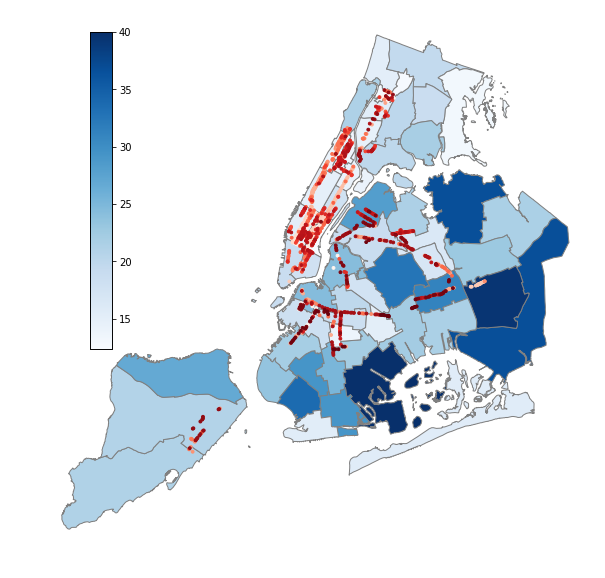

In [50]:
link_shp = GeoDataFrame(link_shp)
fig, ax, cb = cp.choroplethNYC(pumashplc, column='per100', cmap='Blues', cb=True, edgecolor='grey');
linkBB.plot(ax=ax, cmap='Reds', markersize=8);

**Figure 4:** This shows locations of each linkNYC kiosk on a choropleth of the number of stations for every group of 100 people. 

... my colors are off here, but it should show that the most kiosks are in areas that already have some form of broadband internet. 

# Extra credit 1: 
How would you enhance the visibility of this map? you are working with numbers that are mostly very low, and reside near each other, and them have a few much higher value points. Notice that here the high values are interesting though and should not be thrown away!

In [ ]:
pl.hist(link_shp["per100"], bins=30);

To enhance visibility, I'd do serveral things (beyond doing this in ArcMap instead!). Things to explore include: 
- look at each borough in isolation
- create more buckets of identification with geopandas map
- increase fig size for visibility
- make the stations '.' instead of 'o'